In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
df=pd.read_csv('./clean.csv', encoding='latin-1',sep=";")
df.head()

,Ordre de travail,Equipment,Noeud Parent,Classification Equipement,Date début,Type OT
0,OT000001,GCULZ201,GCULZ2,MECANIQUE,2019-01-03,correctif planifié
1,OT000002,GCULZ103,GCULZ1,MECANIQUE,2019-01-02,correctif planifié
2,OT000003,ULPRPH0104,ULPRPH01,MECANIQUE,2019-01-03,correctif planifié
3,OT000011,ULPRPH0104,ULPRPH01,MECANIQUE,2019-01-03,correctif planifié
4,OT000015,ULPRDV0103,ULPRDV01,MECANIQUE,2019-01-01,correctif planifié


In [2]:
df.isnull().sum()


Ordre de travail             0
Equipment                    0
Noeud Parent                 0
Classification Equipement    0
Date début                   0
Type OT                      0
dtype: int64

In [3]:
df['Date début'] = pd.to_datetime(df['Date début'], format='%Y-%m-%d')

In [4]:
df1 = df.groupby(df['Date début'].dt.to_period("M")).size().reset_index(name='Number of Orders')
df1.head()

,Date début,Number of Orders
0,2019-01,399
1,2019-02,252
2,2019-03,307
3,2019-04,296
4,2019-05,230


In [5]:
df1.to_csv('nombre_depanes_par_mois.csv', index=False, encoding='latin-1',sep=";") 



In [6]:
df=pd.read_csv('./nombre_depanes_par_mois.csv', encoding='latin-1',sep=";")

In [7]:
df['Date début'] = pd.to_datetime(df['Date début'], format='%Y-%m')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date début        39 non-null     datetime64[ns]
 1   Number of Orders  39 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 752.0 bytes


In [9]:
df.index = df['Date début']
del df['Date début']
df.head()


,Number of Orders
Date début,
2019-01-01,399
2019-02-01,252
2019-03-01,307
2019-04-01,296
2019-05-01,230


In [10]:
df.tail()

,Number of Orders
Date début,
2021-11-01,296
2021-12-01,305
2022-01-01,230
2022-02-01,232
2022-03-01,34


<AxesSubplot:xlabel='Date début', ylabel='Number of Orders'>

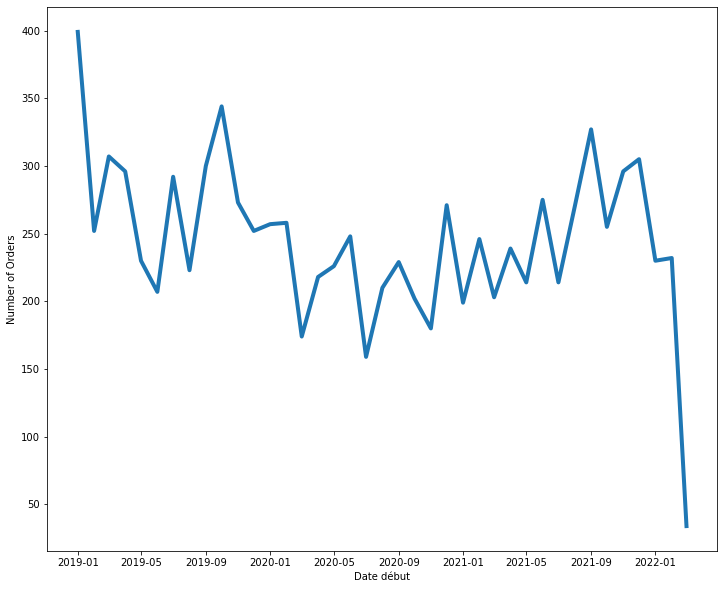

In [11]:
plt.figure(figsize=(12, 10))
sns.lineplot(data=df, x=df.index, y=df['Number of Orders'], linewidth=4)



In [12]:
df.head()

,Number of Orders
Date début,
2019-01-01,399
2019-02-01,252
2019-03-01,307
2019-04-01,296
2019-05-01,230


In [13]:
df.tail()

,Number of Orders
Date début,
2021-11-01,296
2021-12-01,305
2022-01-01,230
2022-02-01,232
2022-03-01,34


In [14]:
msk=(df.index <'2021-07-30')
df_train=df[msk].copy()
df_test=df[~msk].copy()

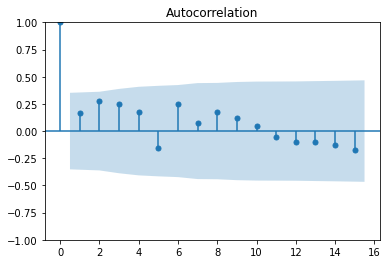

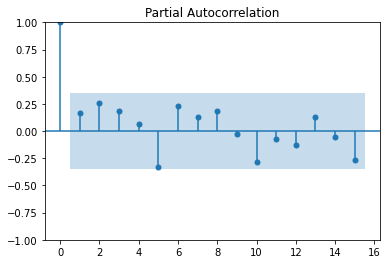

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

In [16]:
from statsmodels.tsa.stattools import adfuller #ADF TEST palue below 0.05 
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.3529588508349232


In [17]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [18]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(5, 1, 0)   Log Likelihood                -153.177
Date:                Fri, 24 May 2024   AIC                            320.354
Time:                        14:15:24   BIC                            330.162
Sample:                    01-01-2019   HQIC                           323.491
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.7375      8.930     -0.755      0.451     -24.239      10.764
ar.L1         -0.5979      0.222     -2.695      0.007      -1.033      -0.163
ar.L2         -0.3038      0.288     -1.056      0.291      -0.868       0.260
ar.L3         -0.0517      0.324     -0.160      0.873      -0.687       0.583
ar.L4          0.0862      0.264      0.327      0.744      -0.431       0.604
ar.L5         -0.4058      0.236     -1.716      0.086      -0.869       0.058
sigma2      1472.4616    608.243      2.421      0.015     280.327    2664.596
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.89   Prob(JB):                         0.76
Heteroskedasticity (H):               0.32   Skew:                            -0.17
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date début'>

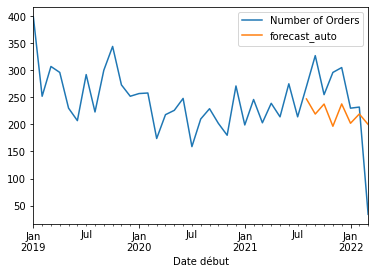

In [19]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

In [20]:
sarima= pm.auto_arima(df_train, m=12)

In [21]:
sarima

ARIMA(order=(5, 1, 0), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

<AxesSubplot:xlabel='Date début'>

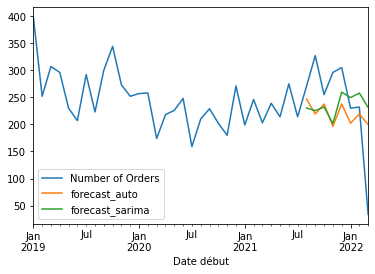

In [22]:
forecast_sarima = sarima.predict(n_periods=len(df_test))
df['forecast_sarima'] = [None]*len(df_train) + list(forecast_sarima)

df.plot()

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
mae = mean_absolute_error(df_test, forecast_test_auto)
r2 = r2_score(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'r2- auto: {r2}')
print(f'rmse - auto: {rmse}')

mae - auto: 65.16824955063615
r2- auto: 0.054941010400665014
rmse - auto: 83.16631357456828


In [25]:
mae = mean_absolute_error(df_test, forecast_sarima)
r2 = r2_score(df_test, forecast_sarima)
rmse = np.sqrt(mean_squared_error(df_test, forecast_sarima))

print(f'mae - auto: {mae}')
print(f'r2 - auto: {r2}')
print(f'rmse - auto: {rmse}')

mae - auto: 68.32669702883967
r2 - auto: -0.08310997566562928
rmse - auto: 89.03366897308824
